### Lista 1 - Econometria 2

* MQO
* Potential Outcomes
* Matching
* RDD

In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t
from IPython.display import display, Markdown

np.set_printoptions(suppress=True)

def get_matrix(v, c, convert=True):
    c = c.split(' ')
    v = v.replace('\n',' ').replace(',','.').split(' ')
    s = (int(len(v)/len(c)),len(c))
    if convert:
        v = np.array(v).astype(float)
    else:
        v = np.array(v)
    matrix = np.reshape(v, s)
    return matrix

def get_confidence_interval(betas, std_errors, vcov, 
                            conf_lv, df):
    t_score = t.ppf(1 - conf_lv, df)
    conf_inter = []
    for i in range(len(betas)):
        upper_bound = betas[i] + t_score*std_err[i]
        lower_bound = betas[i] - t_score*std_err[i]
        conf_inter.append((lower_bound,upper_bound))
    return conf_inter

## 1.
Com os dados da tabela abaixo, estime a regressãoo de $Y$ em função de $X_2$ e $X_3$ e faça os testes da regressão e de cada um dos parâmetros.


In [2]:
# %% (================== Questão 1 ===================) #

# Dados

cols = 'Y X2 X3'
vals ='''800 2 0,8
1160 4 0,7
1580 6 0,5
2010 8 0,4
1890 7 0,2
2600 12 0,2
2070 11 0,8
1890 10 0,7
1830 9 0,6
1740 8 0,1
1380 6 0,5
1060 4 0,4'''

# Transformando em Matrizes

A = get_matrix(v = vals, c= cols)
Y = A[:,0]
X = A.copy()
X[:,0] = 1

# Modelo a ser estimado
# Y = b1 + b2X2 + b3X3 + vt 

# OLS via Statsmodels
df = pd.DataFrame(A,columns=cols.split(' '))
df_exog = sm.add_constant(df.iloc[:,1:])
model = sm.OLS(df.iloc[:,0], df_exog)
result = model.fit()
df

,Y,X2,X3
0,800.0,2.0,0.8
1,1160.0,4.0,0.7
2,1580.0,6.0,0.5
3,2010.0,8.0,0.4
4,1890.0,7.0,0.2
5,2600.0,12.0,0.2
6,2070.0,11.0,0.8
7,1890.0,10.0,0.7
8,1830.0,9.0,0.6
9,1740.0,8.0,0.1


### 1A. 

Calcule os parâmetros $\beta_1, \beta_2, \beta_3$ desse modelo.

Formulas:

$\hat{\beta} = X'X^{-1}X'Y$

In [3]:
# %%  (========= Item A =========) #

# Estimando Beta por meio de Matriz (pg 757 Wooldridge)
# B_hat = (X'X)^-1 X'y

B_hat = inv(X.T @ X) @ X.T @ Y

##  Usando Statsmodels ##
B_hat_sm = result.params

print('Via matrizes:',B_hat)
print('\n')
print('* Via Statsmodels:\n',B_hat_sm)

Via matrizes: [ 789.32955999  149.55929799 -419.25655004]


* Via Statsmodels:
 const    789.329560
X2       149.559298
X3      -419.256550
dtype: float64


### 1B. 

Monte a matriz de residuos deste modelo. Calcule a soma dos quadrados dos resíduos utilizando método matricial.


Formulas:

$SSR = (Y - X \hat{\beta})'(Y - X \hat{\beta}) $

$SSR = \hat{u}'\hat{u}$

$\hat{u} = (Y - X \hat{\beta}) $

In [4]:
# %% (========= Item B =========) #

# Estimando Soma dos quadrados dos residuos por meio de Matriz (pg 757 Wooldridge)
# SSR = (y - XB_hat)' (Y - XB_hat)
# SSR = u_hat' u_hat
# u_hat = y - XB_hat

u_hat = (Y - X @ B_hat)
SSR = u_hat.T @ u_hat 

##  Usando Statsmodels ##
SSR_sm = sum(np.square(result.resid))

display(Markdown(rf'$ SSR = {SSR}$'))
display(Markdown('\n Statsmodels: \n\n '+ rf'$ SSR = {SSR_sm}$'))

$ SSR = 173444.01874617563$


 Statsmodels: 

 $ SSR = 173444.01874617557$

### 1C. 
Calcule o r2 deste modelo.

Formulas:

$SST = \sum (y_i - \bar{y})^2 $

$SSE = \sum (\hat{y_i} - \bar{y})^2 $

$SSR = \sum (hat{u_i})^2 $

$SST = SSE + SSR $

$R^2 = SSE/SST = 1 - SSR/SST$

In [5]:
# %% (========= Item C =========) #

# Estimando o R^2 do modelo (pg 38 - 40 Wooldridge)
# SST = Sum(Yi - Y_mean) ^ 2
# SSE - Sum(Yi_hat - Y_mean) ^ 2
# SSR = Sum(u_hat)^2
# SST = SSE + SSR
# R_squared = SSE/SST = 1 - SSR/SST WE

SST = sum(np.square(Y - np.repeat(np.mean(Y),len(Y))))
SSE = SST - SSR
R2 = SSE/SST

##  Usando Statsmodels ##
R2_sm = result.rsquared

display(Markdown(rf'$ R^2 = {R2}$'))
display(Markdown('\n Statsmodels: \n\n '+ rf'$R^2 = {R2_sm}$'))

$ R^2 = 0.9369070784201032$


 Statsmodels: 

 $R^2 = 0.9369070784201032$

### 1D.
Monte a matriz de variância e covariância deste modelo.


Formulas:

$ X'(y - X\hat{\beta}) = 0 $

$ X' \hat{u} = 0 $

$ \sigma^2 = SSR/(N - k) $

$ Var( u | X ) = \sigma^2 I_n $


In [6]:
# %% (========= Item D =========) #

# Estimando Matriz de Variância-Covariância (pg 759 Wooldridge)
# X'(y - XB_hat) = 0
# X' * u_hat =  0
# sigma2 = SSR/ (N - k)
# Var(u | X) =  sigma_2 * In

sigma_2 = SSR/(X.shape[0] - X.shape[1])
vcov = sigma_2 * inv(X.T @ X)

##  Usando Statsmodels ##
vcov_sm = result.cov_params()

print(pd.DataFrame(vcov))
print('\n\n Statsmodels: \n', vcov_sm)

              0            1             2
0  24104.991220 -1747.647374 -19990.341607
1  -1747.647374   202.342243    570.846328
2 -19990.341607   570.846328  32240.757411


 Statsmodels: 
               const           X2            X3
const  24104.991220 -1747.647374 -19990.341607
X2     -1747.647374   202.342243    570.846328
X3    -19990.341607   570.846328  32240.757411


### 1E. 

Verifique se os $\beta_1, \beta_2, \beta_3$ são significantes ao nível de 5% de significância.


Formulas:

$ \alpha = 0.05$

$ IC = \hat(\beta_j) \pm t_{1-\alpha, n-k} *  S_{\hat{\beta_j}}$

$ t = \frac{\hat{\beta}}{S_{\hat{\beta_j}}}$

In [7]:
# %% (========= Item E =========) #

# Verifica a significancia dos Betas a nivel 5%
conf_lv = 0.05

# Construindo intervalo de Confiança
# Formula de IC:
#  b1  +/-  (t1-∝/2, n-k) * (erro padrão de b1)
  

std_err = np.sqrt(np.diag(vcov))
conf_interval = get_confidence_interval(betas=B_hat, std_errors=std_err, 
                                        vcov = vcov, conf_lv = conf_lv, 
                                        df = X.shape[0] - X.shape[1])

# Testes de Hipótese, obtendo Estatística T e Valor-P
t_score = B_hat/std_err
p_values = t.sf(abs(t_score),  X.shape[0] - X.shape[1])*2 # duas caudas multiplica por 2

##  Usando Statsmodels ##
conf_interval_sm = result.conf_int()
p_values_sm = result.pvalues

display(Markdown(rf'### Intervalos de Confiança'))
print(conf_interval)
print('\n')
print('Statsmodels:\n',conf_interval_sm)

display(Markdown(rf'### P-valor'))
print(p_values)
print('\n')
print('Statsmodels:\n',p_values_sm)

### Intervalos de Confiança

[(504.7244390132717, 1073.934680973375), (123.4838065995088, 175.63478938424845), (-748.4050189975782, -90.10808107474134)]


Statsmodels:
                 0            1
const  438.111966  1140.547154
X2     117.380779   181.737817
X3    -825.442963   -13.070137


### P-valor

[0.00065926 0.00000235 0.044386  ]


Statsmodels:
 const    0.000659
X2       0.000002
X3       0.044386
dtype: float64


## 2. 
A questão anterior adicionamos uma variável _dummy_, que representa a existência ou não de determinado atributo.


In [8]:

# %% (================== Questão 2 ===================) #

cols = 'Y X2 X3 Dummy'
vals = '''800 2 0,8 1
1160 4 0,7 1
1580 6 0,5 1
2010 8 0,4 1
1890 7 0,2 1
2600 12 0,2 1
2070 11 0,8 0
1890 10 0,7 0
1830 9 0,6 0
1740 8 0,1 0
1380 6 0,5 0
1060 4 0,4 0'''

# Transformando em Matrizes

A = get_matrix(v = vals, c= cols)
Y = A[:,0]
X = A.copy()
X[:,0] = 1

# Y = b1 + b2X2 + b3X3 + b4D + vt

# OLS via Statsmodels
df = pd.DataFrame(A,columns=cols.split(' '))
df_exog = sm.add_constant(df.iloc[:,1:])
model = sm.OLS(df.iloc[:,0], df_exog)
result = model.fit()
df

,Y,X2,X3,Dummy
0,800.0,2.0,0.8,1.0
1,1160.0,4.0,0.7,1.0
2,1580.0,6.0,0.5,1.0
3,2010.0,8.0,0.4,1.0
4,1890.0,7.0,0.2,1.0
5,2600.0,12.0,0.2,1.0
6,2070.0,11.0,0.8,0.0
7,1890.0,10.0,0.7,0.0
8,1830.0,9.0,0.6,0.0
9,1740.0,8.0,0.1,0.0


### 2A.
Calcule os parâmetros $\beta_1, \beta_2, \beta_3$ desse modelo.

In [9]:
# %% (========= Item A =========) #
B_hat = inv(X.T @ X) @ X.T @ Y

##  Usando Statsmodels ##
B_hat_sm = result.params
B_hat

print('Via matrizes:',B_hat)
print('\n')
print('* Via Statsmodels:\n',B_hat_sm)

Via matrizes: [ 536.09284948  161.86571415 -327.77786331  238.07634473]


* Via Statsmodels:
 const    536.092849
X2       161.865714
X3      -327.777863
Dummy    238.076345
dtype: float64


### 2B.
Monte a matriz de residuos deste modelo. Calcule a soma dos quadrados dos resíduos utilizando método matricial.

In [10]:
# %% (========= Item B =========) #
u_hat = (Y - X @ B_hat)
SSR = u_hat.T @ u_hat 

##  Usando Statsmodels ##
SSR_sm = sum(np.square(result.resid))

display(Markdown(rf'$ SSR = {SSR}$'))
display(Markdown('\n Statsmodels: \n\n '+ rf'$* SSR = {SSR_sm}$'))

$ SSR = 19854.217281745772$


 Statsmodels: 

 $* SSR = 19854.217281745787$

### 2C.
Calcule o r2 deste modelo.

In [11]:
# %% (========= Item C =========) #
SST = sum(np.square(Y - np.repeat(np.mean(Y),len(Y))))
SSE = SST - SSR
R2 = SSE/SST

##  Usando Statsmodels ##
R2_sm = result.rsquared

display(Markdown(rf'$ R^2 = {R2}$'))
display(Markdown('\n Statsmodels: \n\n '+ rf'$R^2 = {R2_sm}$'))

$ R^2 = 0.9927777239996923$


 Statsmodels: 

 $R^2 = 0.9927777239996923$

### 2D.
Monte a matriz de variância e covariância deste modelo.

In [12]:
# %% (========= Item D =========) #
sigma_2 = SSR/(X.shape[0] - X.shape[1])
vcov = sigma_2 * inv(X.T @ X)

##  Usando Statsmodels ##
vcov_sm = result.cov_params()

print(pd.DataFrame(vcov))
print('\n\n Statsmodels: \n', vcov_sm)

             0           1            2           3
0  4140.447419 -275.417619 -2948.665047 -974.189208
1  -275.417619   28.504654    91.703980   47.342180
2 -2948.665047   91.703980  4287.161050  351.914022
3  -974.189208   47.342180   351.914022  915.868024


 Statsmodels: 
              const          X2           X3       Dummy
const  4140.447419 -275.417619 -2948.665047 -974.189208
X2     -275.417619   28.504654    91.703980   47.342180
X3    -2948.665047   91.703980  4287.161050  351.914022
Dummy  -974.189208   47.342180   351.914022  915.868024


### 2E. 
Verifique se os $\beta_1, \beta_2, \beta_3$ são significantes ao nível de 5% de significância.

In [13]:
# %% (========= Item E =========) #

conf_lv = 0.05
std_err = np.sqrt(np.diag(vcov))
conf_interval = get_confidence_interval(betas=B_hat, std_errors=std_err, 
                                        vcov = vcov, conf_lv = conf_lv, 
                                        df = X.shape[0] - X.shape[1])
t_score = B_hat/std_err
p_values = t.sf(abs(t_score),  X.shape[0] - X.shape[1])*2 # duas caudas multiplica por 2

##  Usando Statsmodels ##
conf_interval_sm = result.conf_int()
p_values_sm = result.pvalues


display(Markdown(rf'### Intervalos de Confiança'))
print(conf_interval)
print('\n')
print('Statsmodels:\n',conf_interval_sm)

display(Markdown(rf'### P-valor'))
print(p_values)
print('\n')
print('Statsmodels:\n',p_values_sm)

### Intervalos de Confiança

[(416.43779776141344, 655.7479012013886), (151.93763373370976, 171.79379457378283), (-449.5344041617826, -206.02132246290614), (181.8002631973779, 294.35242626595704)]


Statsmodels:
                 0           1
const  387.709996  684.475703
X2     149.554016  174.177413
X3    -478.766749 -176.788977
Dummy  168.289023  307.863666


### P-valor

[0.00003257 0.         0.00104491 0.00004927]


Statsmodels:
 const    3.256747e-05
X2       1.520871e-09
X3       1.044908e-03
Dummy    4.926692e-05
dtype: float64


## 3. 
Use os valores descritos na tabela abaixo para ilustrar que $E[\Upsilon_i(0)] - E[\Upsilon_i(1)] = E[\Upsilon_i(0) - \Upsilon_i(1)]$

In [14]:
# %% (================== Questão 3 ===================) #

cols = 'Vila(i) Yi(0) Yi(1) t1'
vals = '''vila1 10 15 5
vila2 15 15 0
vila3 20 30 10
vila4 20 15 -5
vila5 10 20 10
vila6 15 15 0
vila7 15 30 5
average 15 20 5'''

A = get_matrix(v = vals, c= cols, convert=False)
Yi = A[:,1:].astype(float)
df = pd.DataFrame(A,columns = cols.split(' '))
df.index = df.iloc[:,0]
df = df.iloc[:,1:]
df

,Yi(0),Yi(1),t1
Vila(i),,,
vila1,10,15,5
vila2,15,15,0
vila3,20,30,10
vila4,20,15,-5
vila5,10,20,10
vila6,15,15,0
vila7,15,30,5
average,15,20,5


In [15]:
# E[Yi(0)] - E[Yi(1)] = E[Yi(0) - Yi(1)]
np.mean(Yi[:,0]) - np.mean(Yi[:,1]) == np.mean(Yi[:,0] - Yi[:,1]) 

True

## 4. 

Demonstre como chegar nessa igualdade:

$ \frac{1}{N_t} \sum_{i=1}^n(y_i | d_i = 1) - \frac{1}{N_C} \sum_{i=1}^n (y_i | d_i = 0) =  E[\Upsilon^1] - E[\Upsilon^0] + (E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0] ) + (1 - \pi)(ATT - ATU)$

ou

$SDO = ATE + \text{Selection bias} + \text{Heterogeneous treatment effect bias}$


#### Resposta:

Prova da seguinte relação de igualdade:

$ \frac{1}{N_t} \sum_{i=1}^n(y_i | d_i = 1) - \frac{1}{N_C} \sum_{i=1}^n (y_i | d_i = 0) = E [ \Upsilon^1 | D = 1] - E [ \Upsilon^0 | D = 0] + (E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0] ) + (1 - \pi)(ATT - ATU)$

Ou

$ SDO = ATE + (E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0] ) + (1 - \pi)(ATT - ATU)$

ATE é a média ponderada de ATT e ATU:

$ ATE = \pi ATT + (1 - \pi)ATU$

$ ATE = \pi E [ \Upsilon^1 | D = 1] - \pi E [ \Upsilon^0 | D = 1] + (1 - \pi) E [ \Upsilon^1 | D = 0] - (1 - \pi) E [ \Upsilon^0 | D = 0] $

$ ATE = \{ \pi E [ \Upsilon^1 | D = 1] + (1 - \pi) E [ \Upsilon^1 | D = 0] \} - \{ \pi E [ \Upsilon^0 | D = 1] + (1 - \pi) E [ \Upsilon^0 | D = 0] \} $

Mudando a notação para tornar mais fácil a visualização:

$ E [ \Upsilon^1 | D = 1] = a$ 

$ E [ \Upsilon^1 | D = 0] = b$ 

$ E [ \Upsilon^0 | D = 1] = c$ 

$ E [ \Upsilon^0 | D = 0] = d$ 

$ ATE = e$ 

Substituindo temos que:

$ e = \{ \pi a + (1 - \pi) b \} -  \{\pi c + (1 - \pi) d \}$


$ e = \pi a + b - \pi b - \pi c - d + \pi d $

$ 0 = e - \pi a - b + \pi b + \pi c + d - \pi d $

$ a - d = e - \pi a - b + \pi b + \pi c + d - \pi d + a - d$

$ a - d = e + (c - d) + a - \pi a - b + \pi b - c + \pi c + d - \pi d $

$ a - d = e + (c - d) + (1 - \pi)(a - c) - (1 - \pi)(b - d) $


Substituindo de volta temos que:


$ E [ \Upsilon^1 | D = 1] - E [ \Upsilon^0 | D = 0] = ATE + (E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0] ) + (1 - \pi)(ATT - ATU)$



## 5. 
Em que condições teremos a seguinte igualdade? Justifique.

$ \frac{1}{N_t} \sum_{i=1}^n(y_i | d_i = 1) - \frac{1}{N_C} \sum_{i=1}^n (y_i | d_i = 0) =  E[\Upsilon^1] - E[\Upsilon^0]$

ou

$SDO = ATE$

#### Resposta:


Para que $SDO = ATE$ é necessário que os componentes de viés sejam nulos.

Ou seja, o _Selection bias_ $ (E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0] )$ e o _Heterogenous treatment effect bias_ $(1 - \pi)(ATT - ATU)$ devem ser iguais a 0.

Para isso é necessário que $\Upsilon^1$ e $\Upsilon^0$ sejam independentes em relação ao tratamento $  (\Upsilon^1, \Upsilon^0 ){\perp \!\!\! \perp} D$.

Se a ocorrência do tratamento $ D $ independende dos valores dos resultados potenciais, então os resultados de $\Upsilon^1$ e $\Upsilon^0$ serão os mesmos dentro da mesma população.

Nesse caso para todo $\Upsilon^0$ valerá uma relação assim:

$ E [ \Upsilon^0 | D = 1] = E [ \Upsilon^0 ] = E [ \Upsilon^0 | D = 0] $

que implica que:

$ E [ \Upsilon^0 | D = 1] - E [ \Upsilon^0 | D = 0 ] = 0$

Ou seja, _selection bias_ é nulo.

Falta agora eliminar o _heterogenous treatment bias_ . 

Temos que os valores de $ATT$ e $ATU$ são:

$ ATT = E [ \Upsilon^1 | D = 1 ] - E [ \Upsilon^0 | D = 1 ] $

$ ATU = E [ \Upsilon^1 | D = 0 ] - E [ \Upsilon^0 | D = 0 ] $

Como $(\Upsilon^1, \Upsilon^0 ){\perp \!\!\! \perp} D $, então $ ATT - ATU = 0$ 

Eliminando também o viés, tornando $ SDO = ATE $

## 6. 
Suponha que um laboratório esteja testando um novo medicamento que tem como objetivo prolongar a vida de pacientes com câncer. Para realizar o estudo, os cientistas irao dividir sua amostra em dois grupos. Os indivíduos pares são os indivíduos do grupo tratamento e que tomam o medicamento, enquanto que os indivíduos ímpares pertencem ao grupo controle e tomam um placebo. Os efeitos dos medicamento são adversos. Suponha que se o paciente tomar o medicamento, entao ele terá a expectativa de vida $\Upsilon_i^1$ adicional. De maneira análoga, se o paciente tomar o placebo, entao ele terá a expectativa de vida $\Upsilon_i^2$ adicional.


In [16]:
# %% (================== Questão 6 ===================) #

# Dados
cols = 'Paciente Y1 Y2'
vals = '''1 8 6
2 9 5
3 8 4
4 4 3
5 7 2
6 1 1
7 5 4
8 7 6
9 5 4
10 4 5
11 5 2
12 10 3
13 5 4
14 10 5
15 2 1'''

A = get_matrix(v = vals, c= cols)
Yi = A[:,1:].astype(float)
df = pd.DataFrame(A,columns = cols.split(' '))
df.index = df.iloc[:,0]
df = df.iloc[:,1:]
df

,Y1,Y2
Paciente,,
1.0,8.0,6.0
2.0,9.0,5.0
3.0,8.0,4.0
4.0,4.0,3.0
5.0,7.0,2.0
6.0,1.0,1.0
7.0,5.0,4.0
8.0,7.0,6.0
9.0,5.0,4.0


### 6A.
Calcule os Efeitos medios de tratamento.

Formulas:

$ \delta_i = Y_i^1 - Y_i^0 $

$ ATE = E[\delta_i] $

In [17]:
delta_i = df['Y1'] - df['Y2']
ATE = np.mean(delta_i)
ATE

2.3333333333333335

### 6B.  

Calcule os efeitos medios do grupo de tratamento . 

Formulas:

$ ATT =  E[\delta_i | D_i = 1] $

In [18]:
delta_i_D1 = delta_i[delta_i.index%2 == 0]
ATT = np.mean(delta_i_D1)
ATT

2.4285714285714284

### 6C. 

Calcule os efeitos medios do grupo de controle.

Formulas:

$ ATU =  E[\delta_i | D_i = 0] $

In [19]:
delta_i_D0 = delta_i[delta_i.index%2 == 1]
ATU = np.mean(delta_i_D0)
ATU

2.25

### 6D. 
O que voce conclui sobre a eficácia do novo medicamento? 

#### Resposta:

A conclusão é que o médicamento aumenta em média 2.333 anos de vida. Pacientes do grupo de tratamento tiveram um aumento de 2.4285 anos de vida e pacientes do grupo controle teriam um aumento de 2.25 anos de vida se tomassem o medicamento.

## 7. 
Um determinado grupo de pesquisadores quer analisar a taxa de mortalidade média entre fumadores de cigarro e fumadores de cachimbo/charuto. Os pesquisadores possuem os dados da ”tabela 2”, em que há informações sobre a classificação etária dos indivíduos e a taxa de mortalidade para cada subgrupo.

In [32]:
# %% (================== Questão 7 ===================) #

# Dados
cols = 'Age_range Death_sates_Cigarette_smokers #_of_Cigarette_smokers #_of_Pipe_or_cigar_smokers'
vals = '''age20-40 20 65 10
age41-70 40 25 25
age≥71 60 10 65
Total - 100 100'''

A = get_matrix(v = vals, c=cols, convert=False)
df = pd.DataFrame(A, columns=cols.split(' '))
df.index = df.iloc[:,0]
df = df.iloc[:-1,1:].apply(pd.to_numeric,errors='coerce')
df

,Death_sates_Cigarette_smokers,#_of_Cigarette_smokers,#_of_Pipe_or_cigar_smokers
Age_range,,,
age20-40,20,65,10
age41-70,40,25,25
age≥71,60,10,65


### 7A.
Qual e a taxa média de mortalidade para fumantes de cigarro sem subclassificação?. 

Sem subclassificação a taxa média de mortaliade será uma média ponderado da mortalidade onde cada peso é igual a $\frac{N_t}{N}$ e $N_t$ e $N$ são respectivamente o número de pessoas em cada grupo e o número total de pessoas.

In [33]:
avg_death_rate = sum(df.iloc[:,0]*df.iloc[:,1]/df.sum()[1])
avg_death_rate

29.0

### 7B. 
Observe que a distribuição etária dos fumantes de cigarros é exatamente o oposto (em termos de construção) dos fumantes de cachimbo e charuto. Portanto, a distribuição de idades é desequilibrada. Ajuste a taxa de mortalidade para fumantes de cigarro para que tenha a mesma distribuição de idade do grupo de comparação, no caso fumadores de cachimbo e charuto. Qual é a nova taxa média de mortalidade? Aumentou ou diminuiu? 

In [34]:
avg_death_rate = sum(df.iloc[:,0]*df.iloc[:,2]/df.sum()[2])
avg_death_rate

51.0

## 8. 
A tabela 3 fornece informações sobre idade e rendimento salarial de dois grupos, _trainees_ e _non−trainees_. Sabendo que o metodo de _Matched Sample_ é o mais adequado para comparação entre esses dois grupos, analise a diferença salarial entre _trainees_ e _non−trainees_. Há diferença salarial? Monte a tabela de _Matched Sample_.

Formulas:

$ \hat{\delta}_{ATT} = \frac{1}{N_T}\sum_{D_i=1}(Y_i - \frac{1}{M} \sum_{m=1}^M Y_{jm(i)}) $ 

$ \hat{\delta}_{ATE} = \frac{1}{N}\sum_{i=1}^N (2D_i - 1) [ Y_i - (\frac{1}{M} \sum_{m=1}^M Y_{jm(i)}) ] $ 

pg. 191-192 Cunningham

In [59]:
# %% (================== Questão 8 ===================) #

# Dados
cols = 'Unit Age Earnings Unit Age Earnings'
multindex = ['Trainee','Trainee','nonTrainee','nonTrainee']
vals = '''1 18 9500 1 20 8500
2 29 12250 2 27 10075
3 24 11000 3 21 8725
4 27 11750 4 39 12775
5 33 13250 5 38 12550
6 22 10500 6 29 10525
7 19 9750 7 39 12775
8 20 10000 8 33 11425
9 21 10250 9 24 9400
10 30 12500 10 30 10750
- - - 11 33 11425
- - - 12 36 12100
- - - 13 22 8950
- - - 14 18 8050
- - - 15 43 13675
- - - 16 39 12775
- - - 17 19 8275
- - - 18 30 9000
- - - 19 51 15475
- - - 20 48 14800'''

A = get_matrix(v = vals, c=cols, convert=False)
df = pd.DataFrame(A, columns=cols.split(' '))
df = df.apply(pd.to_numeric,errors='coerce')
df.index = df.iloc[:,3]
df = df.drop(['Unit'],axis=1)
index = list(zip(*[multindex,df.columns]))
index = pd.MultiIndex.from_tuples(index)
df.columns = index
df


Trainee          nonTrainee         
         Age Earnings        Age Earnings
Unit                                     
1       18.0   9500.0         20     8500
2       29.0  12250.0         27    10075
3       24.0  11000.0         21     8725
4       27.0  11750.0         39    12775
5       33.0  13250.0         38    12550
6       22.0  10500.0         29    10525
7       19.0   9750.0         39    12775
8       20.0  10000.0         33    11425
9       21.0  10250.0         24     9400
10      30.0  12500.0         30    10750
11       NaN      NaN         33    11425
12       NaN      NaN         36    12100
13       NaN      NaN         22     8950
14       NaN      NaN         18     8050
15       NaN      NaN         43    13675
16       NaN      NaN         39    12775
17       NaN      NaN         19     8275
18       NaN      NaN         30     9000
19       NaN      NaN         51    15475
20       NaN      NaN         48    14800

In [60]:
# Médias
df.mean()

Trainee     Age            24.30
            Earnings    11075.00
nonTrainee  Age            31.95
            Earnings    11101.25
dtype: float64

<AxesSubplot:>

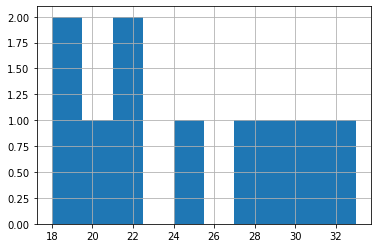

In [61]:
# Distribuição de idade dos trainees
df.Trainee.Age.hist()

<AxesSubplot:>

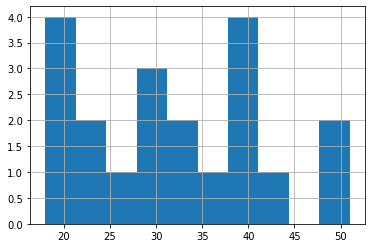

In [62]:
# Distribuição de idade dos non-trainees
df.nonTrainee.Age.hist()

In [63]:
df.Trainee.Age

Unit
1     18.0
2     29.0
3     24.0
4     27.0
5     33.0
6     22.0
7     19.0
8     20.0
9     21.0
10    30.0
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
Name: Age, dtype: float64

In [64]:
def exact_match(val, array):
    m= []
    for i, j in zip(array, range(len(array))):
        if i == val:
            m.append(j + 1 )
    return m

# Exemplo
exact_match(39, df.nonTrainee.Age)

[4, 7, 16]

In [73]:
Y_jm = []
matched = []
ages = list(df.Trainee.Age.dropna())
for i in ages:
    j = (exact_match(i, df.nonTrainee.Age))
    matched.append(j)
    Y_jm.append(df.nonTrainee.Earnings[j].mean())
print(Y_jm)
print(matched)

[8050.0, 10525.0, 9400.0, 10075.0, 11425.0, 8950.0, 8275.0, 8500.0, 8725.0, 9875.0]
[[14], [6], [9], [2], [8, 11], [13], [17], [1], [3], [10, 18]]


In [74]:
matched_sample = pd.DataFrame([matched, ages ,  Y_jm], index = ['Units', 'Age', 'Earnings']).T
matched_sample

,Units,Age,Earnings
0,[14],18.0,8050.0
1,[6],29.0,10525.0
2,[9],24.0,9400.0
3,[2],27.0,10075.0
4,"[8, 11]",33.0,11425.0
5,[13],22.0,8950.0
6,[17],19.0,8275.0
7,[1],20.0,8500.0
8,[3],21.0,8725.0
9,"[10, 18]",30.0,9875.0


In [77]:
delta_i = df.Trainee.Earnings - matched_sample.Earnings
ATE = np.mean(delta_i)
ATE

1388.888888888889

## 9.
Em qual situação o uso de regressão em descontinuidade é recomendado? Dê um exemplo prático e disserte sobre as vantagens desse método.

#### Resposta:


Regressão em descontinuidade são ótimas para eliminar viés de seleção ao estimar o efeito médio de tratamento. Um exemplo prático é por exemplo é o tamanho das multas e prisão de má condução no trânsito. Indivíduos que tiverem um nível de álcool no sange maior que 0.08 recebem maiores multas do que os que não possuem. Você teria 0.08 como um _cutoff_ que a partir de certo momento a variável $X$ para de ter effeitos em $Y$.(pg. 244 Cunningham)

## 10.  
Imagine dois alunos - o primeiro aluno obteve 1240 e o segundo 1250. Esses dois alunos são realmente tão diferentes um do outro? Bem, claro: esses dois alunos individuais são provavelmente muito diferentes. Mas e se tivéssemos centenas de alunos que tiraram 1240 e centenas mais que fizeram 1250. Voce não acha que esses dois grupos são provavelmente muito semelhantes um ao outro em características observáveis e inobserváveis? 

Afinal, por que haveria de repente em 1250 uma grande diferença nas características dos alunos em uma grande amostra? Essae a questão sobre a qual você deve refletir. Se a universidade está escolhendo arbitrariamente um ponto de corte razoavel, há motivos para acreditar que ela também está escolhendo um ponto de corte em que a habilidade natural dos alunos salta exatamente naquele ponto? Para analisar isso , Hoekstra (2009) realizou um estudo,utilizando dados disponibilizados por uma universidade estadual americana, em que realizou a seguinte estimação.

$ ln(earnings) = \psi year + \omega Experience + \theta cohort + \epsilon $

Em que:
* $ \psi $ é um vetor de _dummies_ de anos.
* $ \omega $ é um vetor de _dummies_ para nos de rendimento após o colegial, isto é, anos de experiência.
* $ \theta $ é um vetor de _dummies_ que controlam para o _cohort_ (grupo) em que o aluno se inscreveu na universidade (por exemplo, 1988) 

<br>
<img src='https://mixtape.scunning.com/graphics/rdd_hoekstra2.jpg' width="500" height="600">

<br>

O eixo horizontal do grafico retrata nota do Sat dos indivíduos, enquanto que o eixo
vertical faz a devida correspondencia dos seus ganhos.

### 10A.  
Interprete os dados. Qual a relação entre a nota do SAT e os ganhos estimados? O que explica essa descontinuidade no gráfico?

#### Resposta:


O Trabalho de Hoekstra (2009) mostra pontos das médias ponderadas de salários de indivíduos de acordo com sua pontuação relativa a nota de corte no SAT de uma universidade. A relação é que quanto maior o SAT, maior será o salário futuro em média, com uma descontinuidade na nota de corte que mostra como pessoas que ingressaram na universidade possuiram um salário maior.

### 10B.  
“Estimated Discontinuity = 0.095 (z = 3.01).” O que isso significa?

#### Resposta:


Significa que entrar na universidade tem um efeito de 9,5% a mais nos ganhos de quem não entrou com mais de 99% de confiança, medido na vizinhança do corte.

## 11. 
Ainda pensando em RDDs, explique o conceito de _”bandwidth”_. Como o uso de uma largura de banda maior afeta sua estimativa dos efeitos do tratamento?


#### Resposta:
